/home/kyv/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kyv/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kyv/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kyv/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

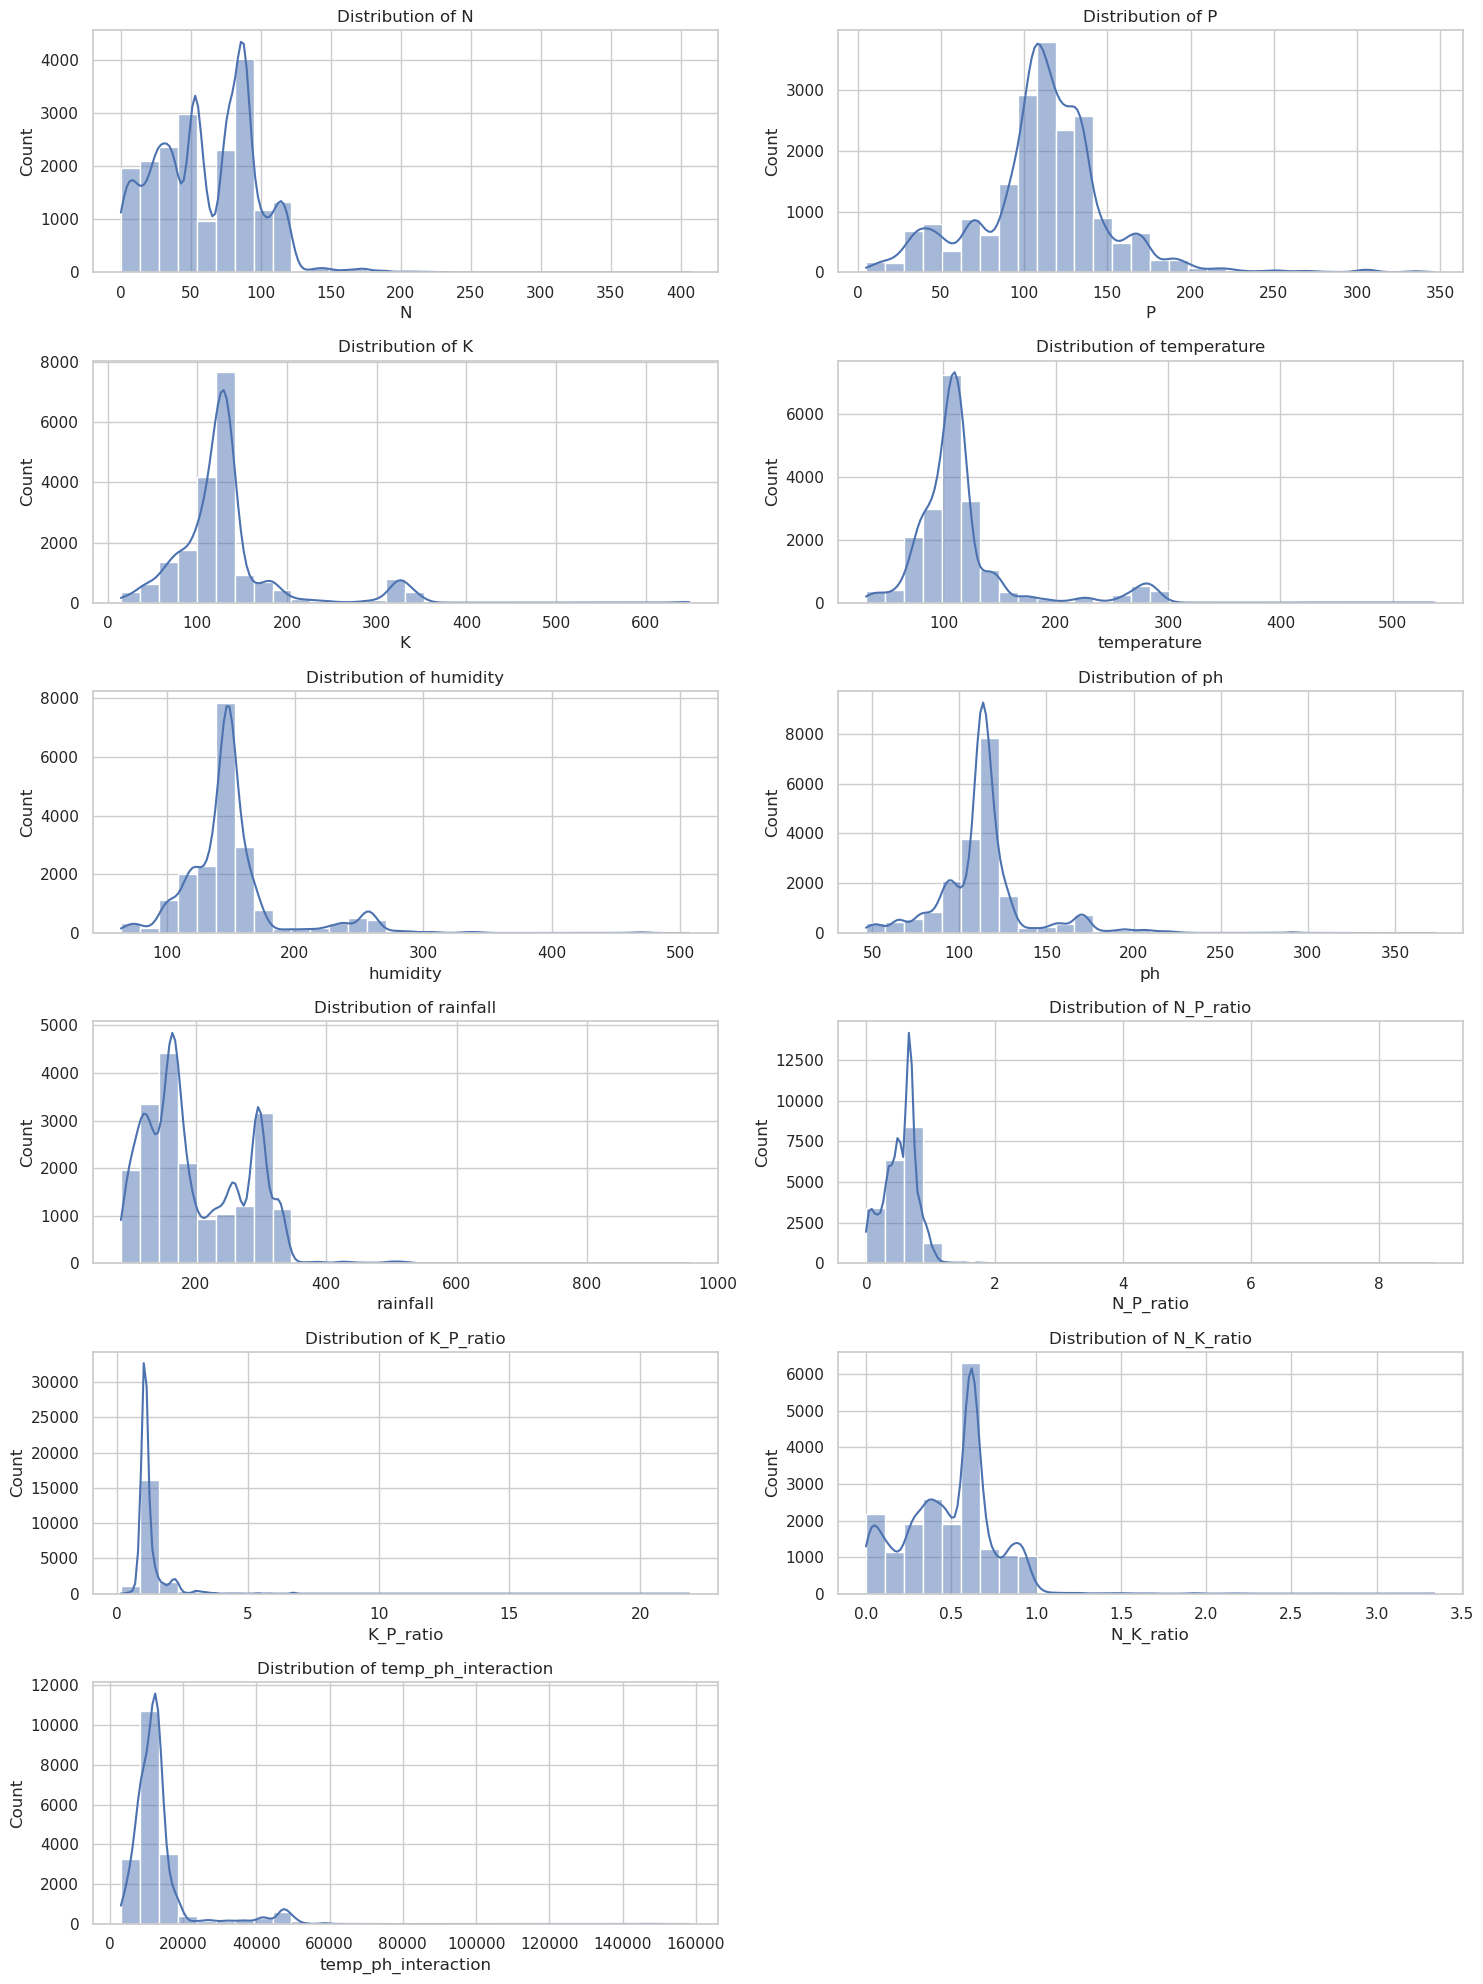

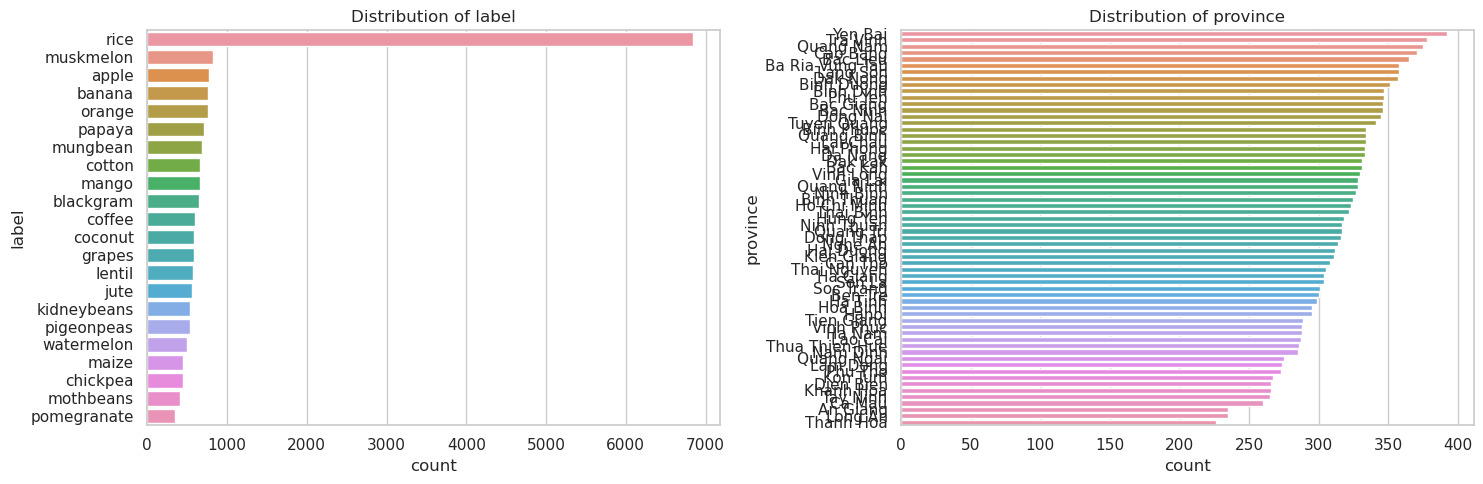

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.read_csv("crop_data.csv")
numerical_features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'N_P_ratio', 'K_P_ratio', 'N_K_ratio', 'temp_ph_interaction']
categorical_features = ['label', 'province']

sns.set(style="whitegrid")

plt.figure(figsize=(15, 20))
for i, feature in enumerate(numerical_features):
    plt.subplot(6, 2, i + 1)
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
for i, feature in enumerate(categorical_features):
    plt.subplot(1, 2, i + 1)
    sns.countplot(y=data[feature], order=data[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


## Train

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Prepare the dataset
X = data.drop(columns=['label', 'province', 'latitude', 'longitude'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [7]:
from sklearn.preprocessing import LabelEncoder
# Label encoding and splitting
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Train
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_report = classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_)

 
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_report = classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_)

# Print
print("Knn accuracy: ", knn_accuracy)
print("Random Forest Accuracy: ", rf_accuracy)
print("XGBoost Accuracy: ", xgb_accuracy)


Knn accuracy:  0.8862644415917843
Random Forest Accuracy:  0.9168164313222079
XGBoost Accuracy:  0.9116816431322208


# Fine Tuning


In [8]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize GridSearchCV for KNN
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid_search.fit(X_train, y_train)

# Get the best parameters and best score for KNN
best_knn_params = knn_grid_search.best_params_
best_knn_score = knn_grid_search.best_score_


In [9]:
# Define the parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

best_rf_params = rf_grid_search.best_params_
best_rf_score = rf_grid_search.best_score_


In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid 
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_grid_search = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), 
    xgb_param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=2
)
xgb_grid_search.fit(X_train, y_train)

best_xgb_params = xgb_grid_search.best_params_
best_xgb_score = xgb_grid_search.best_score_

print("Best XGBoost Parameters:", best_xgb_params)
print("Best XGBoost Cross-Validation Score:", best_xgb_score)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   2.1s
[CV] END colsamp

### Retrain model


In [11]:
from sklearn.metrics import classification_report, accuracy_score

# Retrain KNN with best hyperparameters
best_knn = KNeighborsClassifier(**best_knn_params)
best_knn.fit(X_train, y_train)
y_pred_best_knn = best_knn.predict(X_test)
best_knn_accuracy = accuracy_score(y_test, y_pred_best_knn)
best_knn_report = classification_report(y_test, y_pred_best_knn, target_names=label_encoder.classes_)

print("Best KNN Accuracy:", best_knn_accuracy)
print("Best KNN Classification Report:\n", best_knn_report)


Best KNN Accuracy: 0.893196405648267
Best KNN Classification Report:
               precision    recall  f1-score   support

       apple       0.76      0.78      0.77       157
      banana       0.86      0.92      0.89       160
   blackgram       0.74      0.87      0.80       142
    chickpea       0.78      0.86      0.82        80
     coconut       0.82      0.87      0.85       114
      coffee       0.85      0.79      0.82       122
      cotton       0.84      0.84      0.84       129
      grapes       0.79      0.78      0.78       125
        jute       0.87      0.82      0.84       106
 kidneybeans       0.89      0.88      0.88        88
      lentil       0.87      0.82      0.84       110
       maize       0.92      0.76      0.83       101
       mango       0.84      0.81      0.83       120
   mothbeans       0.88      0.74      0.80        92
    mungbean       0.86      0.85      0.85       124
   muskmelon       0.89      0.95      0.92       167
      orang

In [12]:
# Retrain Random Forest with best hyperparameters
best_rf = RandomForestClassifier(**best_rf_params, random_state=42)
best_rf.fit(X_train, y_train)
y_pred_best_rf = best_rf.predict(X_test)
best_rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
best_rf_report = classification_report(y_test, y_pred_best_rf, target_names=label_encoder.classes_)

print("Best Random Forest Accuracy:", best_rf_accuracy)
print("Best Random Forest Classification Report:\n", best_rf_report)


Best Random Forest Accuracy: 0.9224646983311938
Best Random Forest Classification Report:
               precision    recall  f1-score   support

       apple       0.87      0.88      0.88       157
      banana       0.90      0.93      0.92       160
   blackgram       0.88      0.92      0.90       142
    chickpea       0.88      0.88      0.88        80
     coconut       0.90      0.88      0.89       114
      coffee       0.88      0.81      0.84       122
      cotton       0.90      0.86      0.88       129
      grapes       0.87      0.86      0.87       125
        jute       0.91      0.84      0.87       106
 kidneybeans       0.93      0.92      0.93        88
      lentil       0.90      0.90      0.90       110
       maize       0.93      0.83      0.88       101
       mango       0.88      0.87      0.87       120
   mothbeans       0.91      0.77      0.84        92
    mungbean       0.84      0.88      0.86       124
   muskmelon       0.90      0.96      0.93 

In [13]:
# Initialize XGBoost with the best parameters
best_xgb = XGBClassifier(
    n_estimators=best_xgb_params['n_estimators'],
    max_depth=best_xgb_params['max_depth'],
    learning_rate=best_xgb_params['learning_rate'],
    subsample=best_xgb_params['subsample'],
    colsample_bytree=best_xgb_params['colsample_bytree'],
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
# Retrain the model
best_xgb.fit(X_train, y_train)

# Make predictions
y_pred_best_xgb = best_xgb.predict(X_test)

# Evaluate the model
best_xgb_accuracy = accuracy_score(y_test, y_pred_best_xgb)
best_xgb_report = classification_report(y_test, y_pred_best_xgb, target_names=label_encoder.classes_)

print("Best XGBoost Accuracy:", best_xgb_accuracy)
print("Best XGBoost Classification Report:\n", best_xgb_report)

Best XGBoost Accuracy: 0.9173299101412067
Best XGBoost Classification Report:
               precision    recall  f1-score   support

       apple       0.85      0.86      0.85       157
      banana       0.93      0.94      0.93       160
   blackgram       0.90      0.90      0.90       142
    chickpea       0.84      0.88      0.86        80
     coconut       0.94      0.89      0.91       114
      coffee       0.88      0.82      0.85       122
      cotton       0.88      0.83      0.86       129
      grapes       0.87      0.86      0.87       125
        jute       0.91      0.83      0.87       106
 kidneybeans       0.94      0.92      0.93        88
      lentil       0.90      0.89      0.89       110
       maize       0.91      0.84      0.88       101
       mango       0.89      0.85      0.87       120
   mothbeans       0.91      0.79      0.85        92
    mungbean       0.84      0.89      0.86       124
   muskmelon       0.88      0.94      0.91       167
  

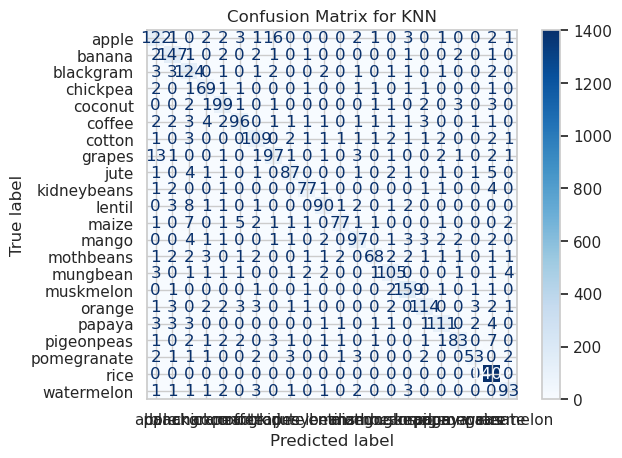

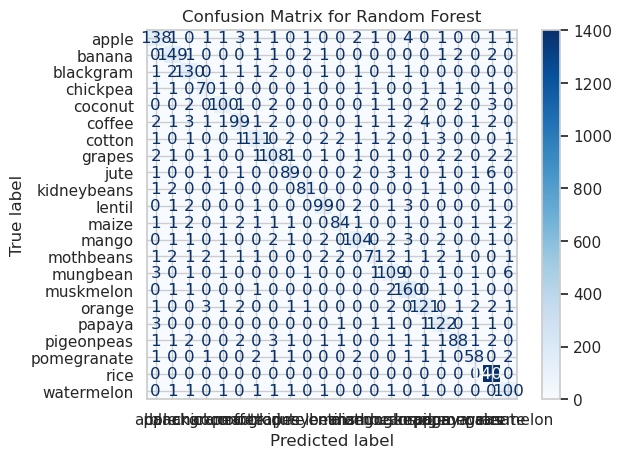

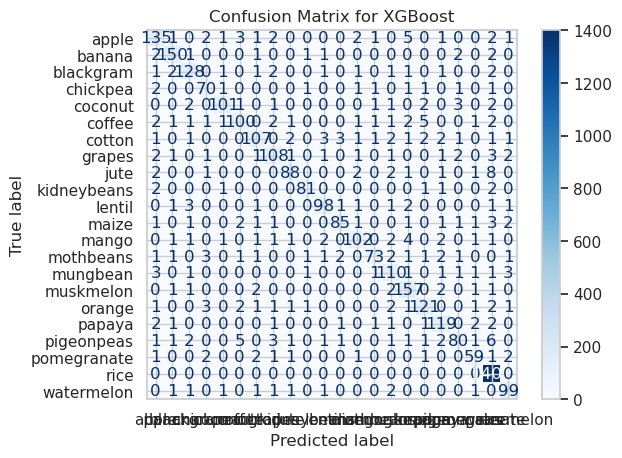

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, y_pred_best_knn, label_encoder.classes_, 'KNN')

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, y_pred_best_rf, label_encoder.classes_, 'Random Forest')

# Plot confusion matrix for XGBoost
plot_confusion_matrix(y_test, y_pred_best_xgb, label_encoder.classes_, 'XGBoost')


In [15]:
import joblib

# Save the KNN model
joblib.dump(best_knn, 'best_knn_model.joblib')

# Save the Random Forest model
joblib.dump(best_rf, 'best_rf_model.joblib')

# Save the XGBoost model
joblib.dump(best_xgb, 'best_xgb_model.joblib')


['best_xgb_model.joblib']